This notebook investigates the student population given incoming attributes

# Preparing the data
We need to load pre survey (incoming attitudes), post survey (demographics data), and worksheet (incoming knowledge).

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is converted to HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [37]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import ranksums
import seaborn as sns
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10, 6
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Grabbing the worksheet data

In [3]:
%reload_ext utils_read_parsing
#grab worksheet data - beers
worksheets = get_worksheet_metadata('beers')
pre_b = get_pre_worksheet(sim='beers')

ids = get_students_to_analyze_log_worksheets('beers')
pre_b = pre_b[pre_b['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre_b['sid'] = pre_b['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])

#grab worksheet data - caps
worksheets = get_worksheet_metadata('caps')
pre_c = get_pre_worksheet(sim='caps')

ids = get_students_to_analyze_log_worksheets('caps')
pre_c= pre_c[pre_c['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre_c['sid'] = pre_c['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])

pre_b.index = pre_b['sid']
pre_c.index = pre_c['sid']
pre_b.drop(['Student ID','sid'],axis=1,inplace=True)
pre_c.drop(['Student ID','sid'],axis=1,inplace=True)

## Grabbing survey data

In [4]:
pre_survey_df = pd.read_csv('pre_survey_results.txt', sep='\t')
pre_survey_df.index = pre_survey_df['sid']
pre_survey_df.drop(['Unnamed: 0','sid'],inplace=True,axis=1)
pre_survey_df.head()

,[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs],similar_L,similar_C,same_L,same_C,prior_number_virtual_labs,perceivedvalue.0-boring,...,taskinterpretation.0-investigate the basic mechanics of the topic at hand,taskinterpretation.1-design my own experiments that can help me understand the topic at hand,taskinterpretation.2-memorize information about the topic at hand,taskinterpretation.3-complete a certain number of questions,taskinterpretation.4-develop scientific reasoning skills,pocc.0-learning the basic concepts,pocc.1-testing my ideas and theories,pocc.2-answering given questions,pocc.3-memorizing key information,pocc.4-exploring the topic
sid,,,,,,,,,,,,,,,,,,,,,
77047160,1.0,1.0,1.0,NaN,0,0,0,0,2,Mostly,...,Mostly,Somewhat,Mostly,Somewhat,Somewhat,Often,Often,Often,Sometimes,Often
23836160,1.0,1.0,NaN,NaN,0,0,0,0,0,Somewhat,...,Definitely,Definitely,Mostly,Definitely,Definitely,Often,Sometimes,Sometimes,Sometimes,Often
64006159,NaN,1.0,1.0,NaN,0,0,0,0,1,Not at all,...,Somewhat,Somewhat,Somewhat,Mostly,Somewhat,Often,Often,Often,Often,Sometimes
24566161,1.0,1.0,1.0,NaN,0,1,0,0,3,Somewhat,...,Mostly,Definitely,Mostly,Definitely,Mostly,Almost always,Almost always,Often,Often,Often
46792161,NaN,1.0,NaN,NaN,1,0,0,0,2,Somewhat,...,Definitely,Somewhat,Not at all,Mostly,Definitely,Often,Often,Often,Sometimes,Almost always


In [5]:
post_survey_df = pd.read_csv('post_survey_results.txt', sep='\t')
post_survey_df = post_survey_df[['age','english.0-writing','english.1-reading','gender-Gender non conforming/non-binary','gender-Man','gender-Prefer not to answer','gender-Woman','major','year-1st year undergraduate','year-2nd year undergraduate','year-3rd year undergraduate','year-4th year undergraduate','sim','sim_index','sid']]
post_survey_df.index = post_survey_df['sid']
post_survey_df.fillna(0,inplace=True)
post_survey_df = post_survey_df[post_survey_df['sim_index']==2]
post_survey_df.drop(['sid'],axis=1,inplace=True)
post_survey_df.head()

,age,english.0-writing,english.1-reading,gender-Gender non conforming/non-binary,gender-Man,gender-Prefer not to answer,gender-Woman,major,year-1st year undergraduate,year-2nd year undergraduate,year-3rd year undergraduate,year-4th year undergraduate,sim,sim_index
sid,,,,,,,,,,,,,,
77047160,18-19,Fluent,Fluent,0.0,0.0,0.0,1.0,*Non science or applied science major,1.0,0.0,0.0,0.0,Capacitance,2
90447168,20-22,Average,Fluent,0.0,1.0,0.0,0.0,*Undeclared,1.0,0.0,0.0,0.0,Capacitance,2
24511163,20-22,Fluent,Fluent,0.0,1.0,0.0,0.0,Mechanical Engineering,1.0,0.0,0.0,0.0,Capacitance,2
27451164,18-19,Fluent,Fluent,0.0,0.0,0.0,1.0,Electrical Engineering,1.0,0.0,0.0,0.0,Capacitance,2
46792161,18-19,Fluent,Fluent,0.0,1.0,0.0,0.0,Mechanical Engineering,1.0,0.0,0.0,0.0,Capacitance,2


## Putting it together

In [6]:
data = pd.concat([pre_b,pre_c,post_survey_df,pre_survey_df],axis=1)
data.rename(columns={"sim": "second sim"},inplace=True)
data.drop('sim_index',axis=1,inplace=True)
data.reset_index(inplace=True)

In [7]:
data.sort_values('sid').head(12)

,sid,Concentration,Wavelength,Width,Area,Separation,Battery voltage,age,english.0-writing,english.1-reading,...,taskinterpretation.0-investigate the basic mechanics of the topic at hand,taskinterpretation.1-design my own experiments that can help me understand the topic at hand,taskinterpretation.2-memorize information about the topic at hand,taskinterpretation.3-complete a certain number of questions,taskinterpretation.4-develop scientific reasoning skills,pocc.0-learning the basic concepts,pocc.1-testing my ideas and theories,pocc.2-answering given questions,pocc.3-memorizing key information,pocc.4-exploring the topic
0,10127163,1.0,1.0,1.0,3,3,3,20-22,Fluent,Fluent,...,Definitely,Not at all,Not at all,Somewhat,Definitely,Almost always,Often,Often,Often,Almost always
1,10192168,1.0,1.0,1.0,1,1,1,18-19,Fluent,Fluent,...,Mostly,Definitely,Not at all,Definitely,Definitely,Often,Often,Often,Often,Often
2,10232160,1.0,1.0,1.0,1,1,1,18-19,Average,Average,...,Mostly,Mostly,Somewhat,Mostly,Somewhat,Almost always,Often,Often,Sometimes,Often
3,10375163,0.0,1.0,1.0,1,1,0,18-19,Fluent,Fluent,...,Mostly,Mostly,Somewhat,Definitely,Mostly,Sometimes,Almost never,Almost never,Sometimes,Almost never
4,10420167,1.0,1.0,0.0,2,2,3,18-19,Fluent,Fluent,...,Definitely,Somewhat,Not at all,Mostly,Mostly,Often,Almost always,Often,Sometimes,Often
5,10537160,1.0,1.0,0.0,0,0,0,18-19,Fluent,Fluent,...,Mostly,Not at all,Not at all,Somewhat,Somewhat,Sometimes,Sometimes,Often,Almost never,Almost never
6,10561164,2.0,1.0,2.0,1,2,3,20-22,Fluent,Fluent,...,Mostly,Mostly,Not at all,Mostly,Somewhat,Often,Almost never,Often,Almost never,Sometimes
7,10708152,2.0,1.0,2.0,1,1,1,18-19,Fluent,Fluent,...,Definitely,Somewhat,Not at all,Definitely,Mostly,Often,Almost always,Almost always,Sometimes,Almost always
8,10866146,3.0,1.0,1.0,1,2,1,17 and under,Fluent,Fluent,...,Mostly,Somewhat,Mostly,Somewhat,Somewhat,Sometimes,Often,Often,Sometimes,Sometimes
9,10908162,2.0,0.0,0.0,0,1,1,18-19,Average,Average,...,Mostly,Mostly,Mostly,Somewhat,Mostly,Almost always,Almost always,Often,Often,Almost always


## Exporting the data

In [8]:
export_data = data.copy()
export_data.to_csv('dataframe_all_incoming_factors_by_student.csv')

## Convert lickert scale and other values from strings to integers

In [9]:
value_converter2 = {
    'Prefer not to answer':0,
    '20-22':21,
    '18-19':19,
    '17 and under':17,
    'Fluent':3,
    'Average':2,
    'Beginner':1,
    'Absorbance':2,
    'Capacitance':1,
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    'Almost always':4,
    'Sometimes':2,
    'Almost never':1,
    'Often':3,
}

In [10]:
for value,replacement in value_converter2.iteritems():
    data = data.replace(value,replacement)
data.fillna(0,inplace=True)
data.head()

,sid,Concentration,Wavelength,Width,Area,Separation,Battery voltage,age,english.0-writing,english.1-reading,...,taskinterpretation.0-investigate the basic mechanics of the topic at hand,taskinterpretation.1-design my own experiments that can help me understand the topic at hand,taskinterpretation.2-memorize information about the topic at hand,taskinterpretation.3-complete a certain number of questions,taskinterpretation.4-develop scientific reasoning skills,pocc.0-learning the basic concepts,pocc.1-testing my ideas and theories,pocc.2-answering given questions,pocc.3-memorizing key information,pocc.4-exploring the topic
0,10127163,1.0,1.0,1.0,3,3,3,21,3,3,...,4,1,1,2,4.0,4,3,3,3,4
1,10192168,1.0,1.0,1.0,1,1,1,19,3,3,...,3,4,1,4,4.0,3,3,3,3,3
2,10232160,1.0,1.0,1.0,1,1,1,19,2,2,...,3,3,2,3,2.0,4,3,3,2,3
3,10375163,0.0,1.0,1.0,1,1,0,19,3,3,...,3,3,2,4,3.0,2,1,1,2,1
4,10420167,1.0,1.0,0.0,2,2,3,19,3,3,...,4,2,1,3,3.0,3,4,3,2,3


In [11]:
for c in data.columns:
    if data[c].dtype not in ['int64','float64']:
        print c, data[c].dtype

major object


In [12]:
data.drop('major',axis=1,inplace=True)

In [13]:
for c in data.columns:
    print c

sid
Concentration
Wavelength
Width
Area
Separation
Battery voltage
age
english.0-writing
english.1-reading
gender-Gender non conforming/non-binary
gender-Man
gender-Prefer not to answer
gender-Woman
year-1st year undergraduate
year-2nd year undergraduate
year-3rd year undergraduate
year-4th year undergraduate
second sim
[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory]
[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]
[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory]
[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs]
similar_L
similar_C
same_L
same_C
prior_number_virtual_labs
perceivedvalue.0-boring
perceivedvalue.1-productive

In [14]:
demo_columns = ["age","english.0-writing","english.1-reading","gender-Gender non conforming/non-binary","gender-Man","gender-Prefer not to answer","gender-Woman","year-1st year undergraduate","year-2nd year undergraduate","year-3rd year undergraduate","year-4th year undergraduate","second sim","[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory]","[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]","[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory]","[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs]","similar_L","similar_C","same_L","same_C","prior_number_virtual_labs"]
att_columns = ["perceivedvalue.0-boring","perceivedvalue.1-productive","perceivedvalue.2-useless","perceivedvalue.3-engaging","taskinterpretation.0-investigate the basic mechanics of the topic at hand","taskinterpretation.1-design my own experiments that can help me understand the topic at hand","taskinterpretation.2-memorize information about the topic at hand","taskinterpretation.3-complete a certain number of  questions","taskinterpretation.4-develop scientific reasoning skills","pocc.0-learning the basic concepts","pocc.1-testing my ideas and theories","pocc.2-answering given questions","pocc.3-memorizing key information","pocc.4-exploring the topic"]
know_columns = ['Concentration','Wavelength','Width','Area','Separation','Battery voltage']

# Analysis of incoming attributes

In [15]:
N = len(set(data['sid']))
print "The study includes {0} students.".format(N)

The study includes 148 students.


## What are their incoming attitudes?

### Descriptives

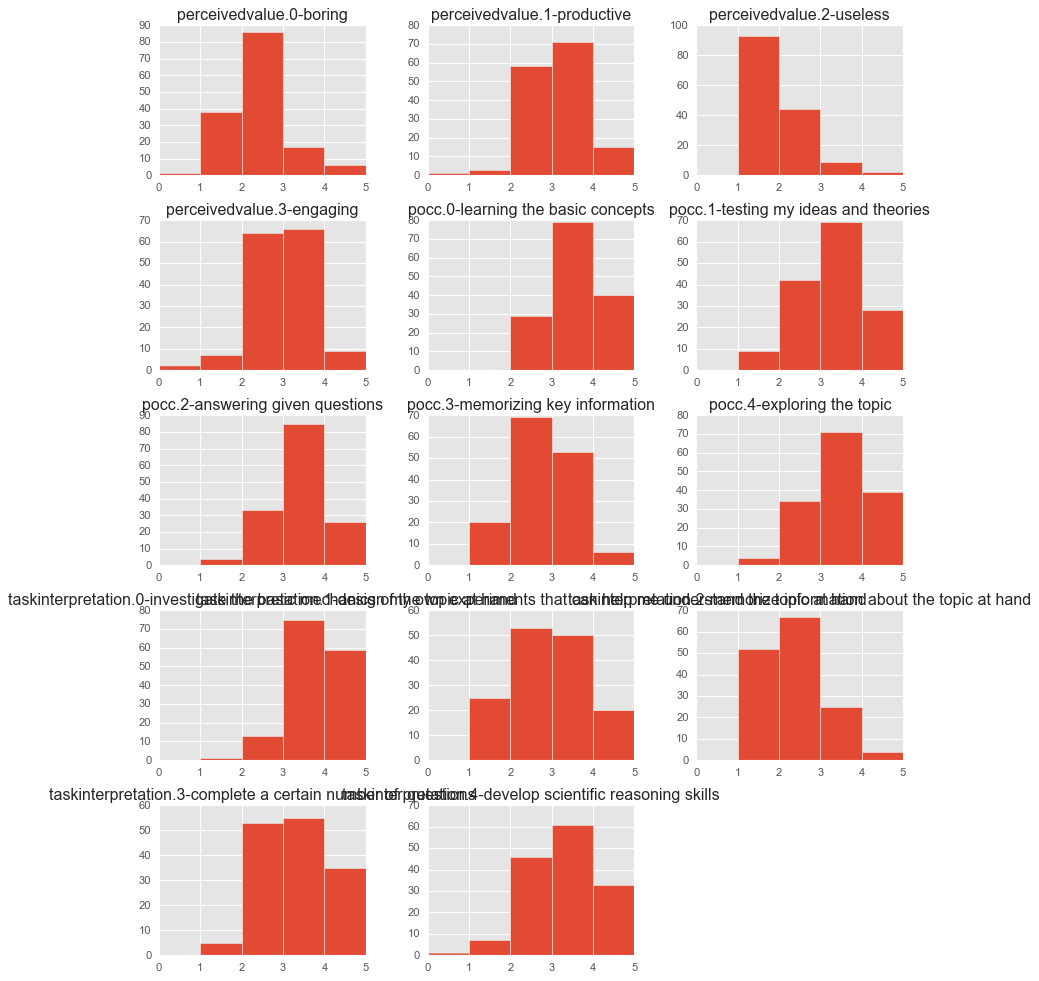

In [16]:
data[att_columns].hist(figsize=(12,15),layout=(len(att_columns)/3+1,3),bins=[0,1,2,3,4,5]);

Clearly, many attitude questions are related. Let's investigate how much:

### Relationship between attitude measures

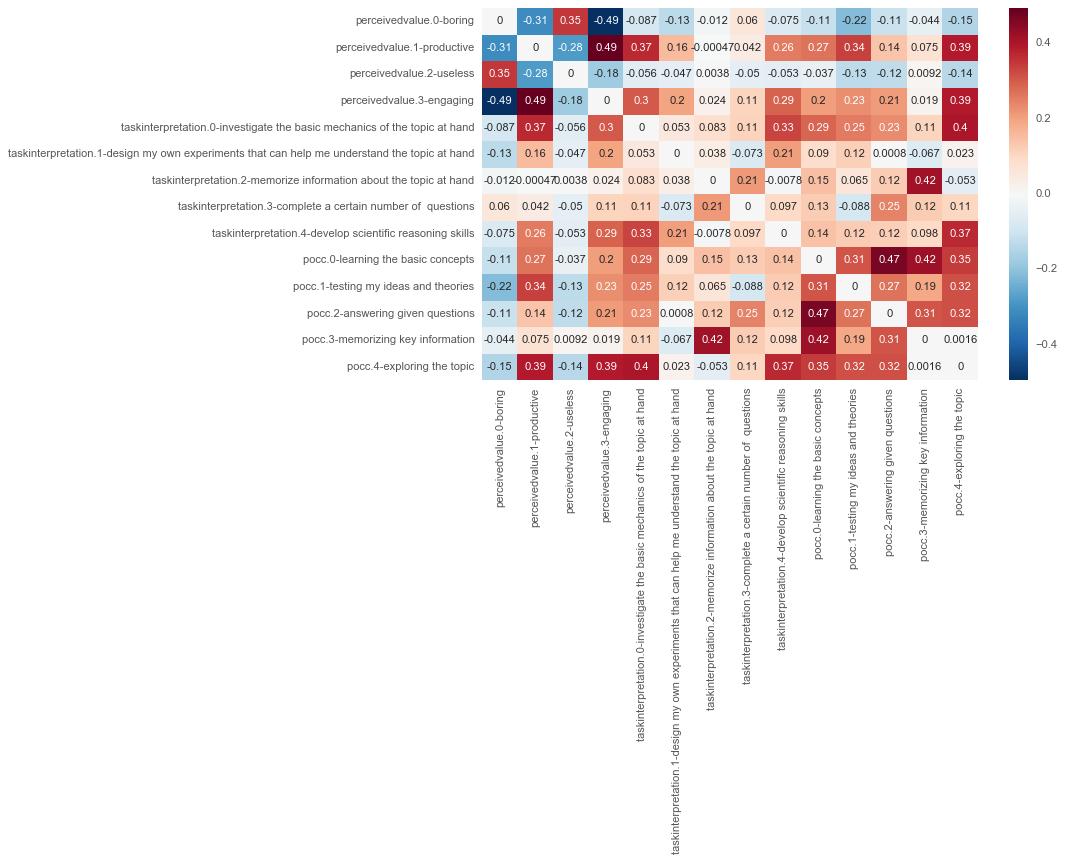

In [17]:
from scipy.stats import spearmanr
correlation_matrix = np.zeros((len(att_columns),len(att_columns)))
for i,att_i in enumerate(att_columns):
    for j,att_j in enumerate(att_columns):
        r,p = spearmanr(data[att_i],data[att_j])
        correlation_matrix[i,j] = r
#         if r>= 0.4 or r<=-0.4:
#             print att_i,att_j,r,p

np.fill_diagonal(correlation_matrix,0)
# correlation_matrix[(correlation_matrix<0.4)&(correlation_matrix>-0.4)] = 0
sns.heatmap(correlation_matrix,yticklabels=att_columns,xticklabels=att_columns,annot=True);

All the POCC type questions are highly correlated between each other (0.3,0.4).
All the perveiced value questions are also highly correlated or anti-correlated (0.3,0.4) which is great since they were deisgned that way ("Do you think the activity will be productive/useless, boring/engaging"). What is interesting is that if they find it productive they also find it engaging.

### What are the principle factors of attitudes? (PCA)

In [18]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit(data[att_columns])
pca.explained_variance_ratio_.cumsum()

array([ 0.23 ,  0.366,  0.463,  0.555,  0.639,  0.702,  0.753,  0.802,
        0.846,  0.888])

The first three components of the PCA exaplined almost 50% of the data. Let's stick to 2 to simplify our analysis

In [19]:
NC = 2
pca = decomposition.PCA(n_components=NC)
pca.fit(data[att_columns])
X = pca.transform(data[att_columns])
data['PC1'] = zip(*X)[0]
data['PC2'] = zip(*X)[1]

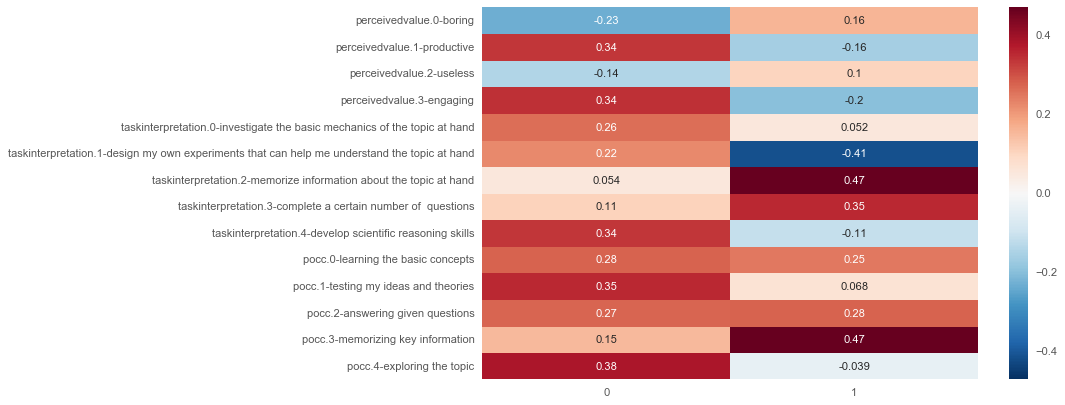

In [20]:
sns.heatmap(pca.components_.T,yticklabels=att_columns,annot=True)

Looking at items that are part of the PC (by a factor of 0.3 percent). We can interpret the PC this way:

**PC 1** - Students think:
* the activity will be engaging, productive
* the activity is design to develop scientific reasoning skills
* they can do a good job of exploring the topic and testing their ideas.
"the engaged explorers"

**PC 2** - Students think:
* the activity is not designed to design their own experiments
* the activity is design to memorize information and complete a certain number of questions
* they can do a good job of memorizing key information
"the robots being tested"

Since the PCs are orthogonal, we have 4 types of students:
1. The engaged exploring robots (++)
2. The unrobotic engaged explorers (+-)
3. The unrobotic not engaged not exploring (--)
4. The not engaged not exploring robots (-+)

### Clustering into two attitudinal groups

In [21]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=2, n_init=10, verbose=0).fit(data[att_columns])
data['cluster_2_label'] = clusters.labels_

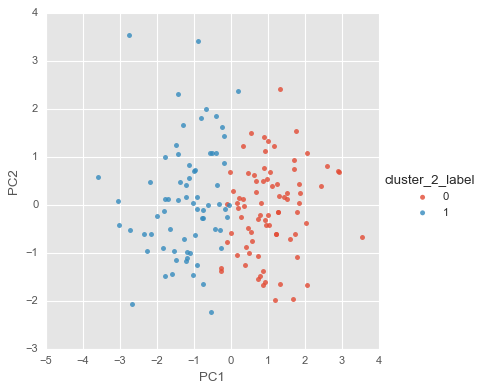

In [22]:
sns.lmplot(x='PC1', y='PC2',data=data,fit_reg=False,hue='cluster_2_label')

The clusters split PC1 exactly which makes since: kmeans clustering divides by the variables that explain most of the variance!

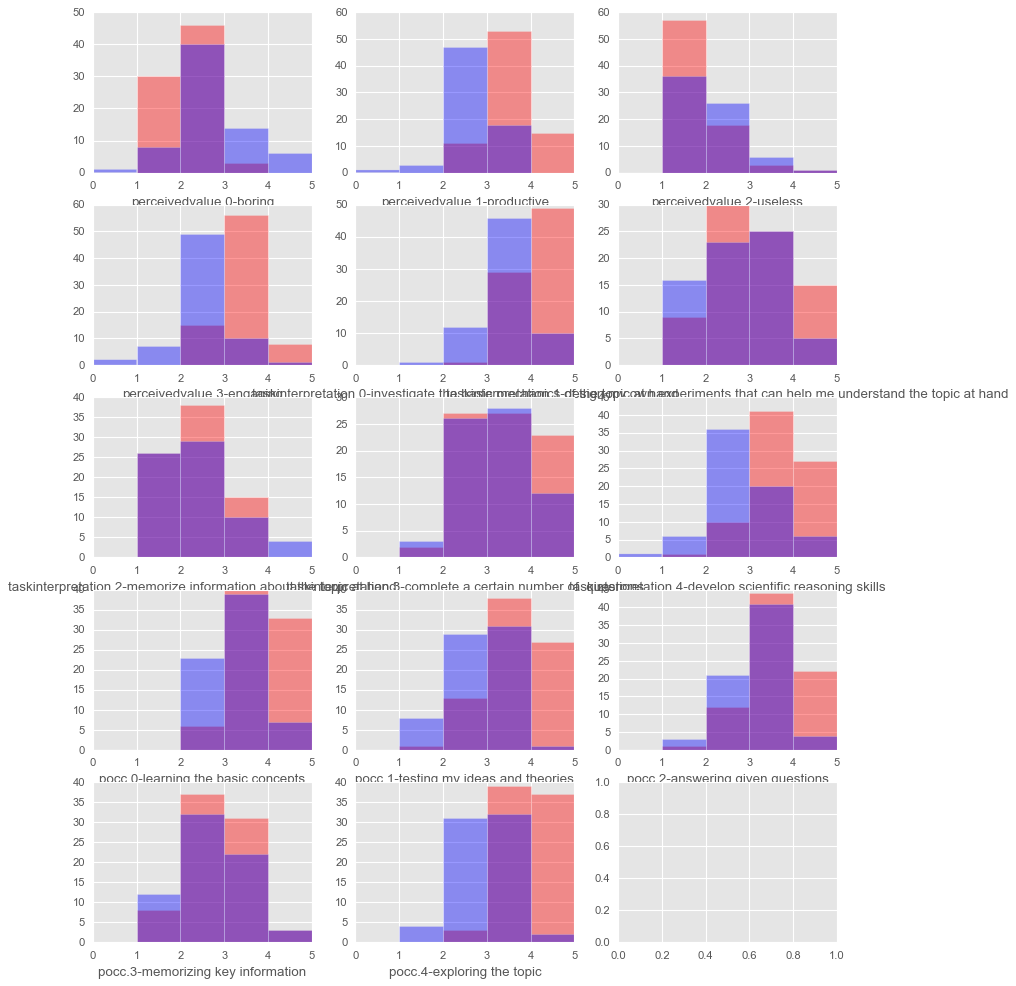

In [23]:
fig,axes = plt.subplots(nrows=len(att_columns)/3+1,ncols=3,figsize=(12,15))
for ax,col in zip(axes.reshape(-1),att_columns):
    sns.distplot(data[data['cluster_2_label']==0][col],ax=ax,bins=[0,1,2,3,4,5],kde=False,label='0',color='red');
    sns.distplot(data[data['cluster_2_label']==1][col],ax=ax,bins=[0,1,2,3,4,5],kde=False,label='1',color='blue');

Clearly, the "red" students think:
* the activity will be productive, not boring, no useless, and engaging
* the activity was design to develop scientific reasoning skills and test their ideas
* they can do a good job a exploring the topic at hand

## Incoming knowledge

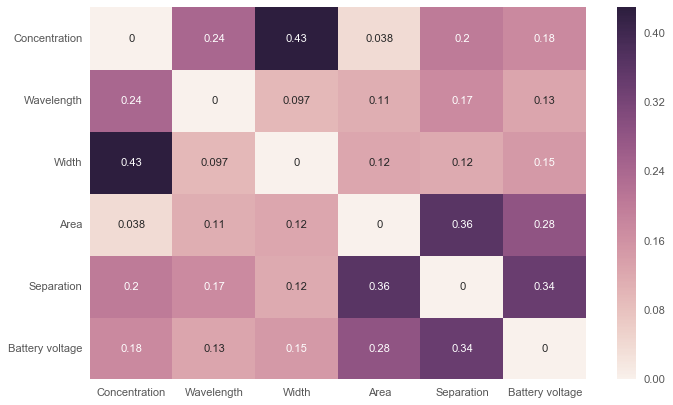

In [24]:
from scipy.stats import spearmanr
correlation_matrix = np.zeros((len(know_columns),len(know_columns)))
for i,att_i in enumerate(know_columns):
    for j,att_j in enumerate(know_columns):
        r,p = spearmanr(data[att_i],data[att_j])
        correlation_matrix[i,j] = r
#         if r>= 0.4 or r<=-0.4:
#             print att_i,att_j,r,p

np.fill_diagonal(correlation_matrix,0)
# correlation_matrix[(correlation_matrix<0.4)&(correlation_matrix>-0.4)] = 0
sns.heatmap(correlation_matrix,yticklabels=know_columns,xticklabels=know_columns,annot=True);

## All together

In [25]:
data['incoming_knowledge_L'] = (data['Concentration']+data['Width']+data['Wavelength'])
data['incoming_knowledge_C'] = (data['Area']+data['Separation']+data['Battery voltage'])
data['incoming_knowledge_all'] = (data['Area']+data['Separation']+data['Battery voltage']+data['Concentration']+data['Width']+data['Wavelength'])

Is incoming knowledge related to incoming attitude?

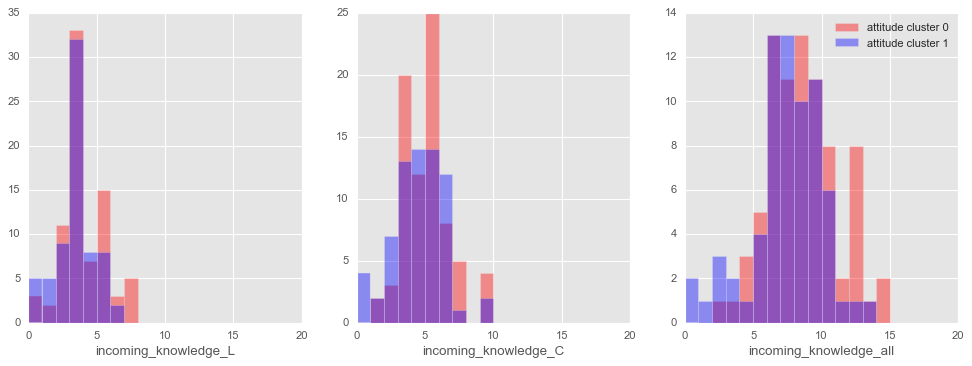

In [26]:
cols = ['incoming_knowledge_L','incoming_knowledge_C','incoming_knowledge_all']
fig,axes = plt.subplots(nrows=1,ncols=len(cols),figsize=(15,5))
for ax,col in zip(axes.reshape(-1),cols):
    sns.distplot(data[data['cluster_2_label']==0][col],ax=ax,bins=range(0,20),kde=False,label='attitude cluster 0',color='red');
    sns.distplot(data[data['cluster_2_label']==1][col],ax=ax,bins=range(0,20),kde=False,label='attitude cluster 1',color='blue');
plt.legend()

# Picking out students

We want 8 students, 2 for each type:
* high attitude (cluster=0, PC1>2), high knowledge (incoming_knowledge_L ==8)
* high attitude (cluster=0, PC1>2), low knowledge (incoming_knowledge_L ==3)
* low attitude (cluster=1, PC1<-2), low knowledge (incoming_knowledge_L ==3)
* low attitude (cluster=1, PC1<-2), high knowledge (incoming_knowledge_L ==8)

In [27]:
# print 'a',data[(data['cluster_2_label']==0)&(data['incoming_knowledge_L']>=6)]['sid']
# print 'b',data[(data['cluster_2_label']==0)&(data['incoming_knowledge_L']==2)]['sid']
# print 'c',data[(data['cluster_2_label']==1)&(data['incoming_knowledge_L']==2)]['sid']
# print 'd',data[(data['cluster_2_label']==1)&(data['incoming_knowledge_L']>=6)]['sid']

In [28]:
print 'a',data[(data['PC1']>2)&(data['incoming_knowledge_L']>=6)]['sid']
print 'b',data[(data['PC1']>2)&(data['incoming_knowledge_L']==2)]['sid']
print 'c',data[(data['PC1']<-2)&(data['incoming_knowledge_L']==3)]['sid']
print 'd',data[(data['PC1']<-2)&(data['incoming_knowledge_L']>=6)]['sid']

a Series([], Name: sid, dtype: int64)
b 73    16657165
Name: sid, dtype: int64
c 59     15298166
67     16233163
146    89047164
Name: sid, dtype: int64
d Series([], Name: sid, dtype: int64)


In [43]:
columns = ['sid',"Concentration","Wavelength","Width","perceivedvalue.0-boring","perceivedvalue.1-productive","taskinterpretation.1-design my own experiments that can help me understand the topic at hand","pocc.4-exploring the topic"]
exploration = data[data['sid'].isin([19989152,10537160,13654167,11929166])][columns]
exploration['Fakename'] = ['Saturn','Tatouine','Ursula','Venus']
exploration['knowledge'] = ['low','high','low','high']
exploration['incoming_attitude'] = ['low','high','high','low']
exploration.sort_values('Concentration',inplace=True)
exploration

,sid,Concentration,Wavelength,Width,perceivedvalue.0-boring,perceivedvalue.1-productive,taskinterpretation.1-design my own experiments that can help me understand the topic at hand,pocc.4-exploring the topic,Fakename,knowledge,incoming_attitude
5,10537160,1.0,1.0,0.0,3.0,2.0,1,1,Saturn,low,low
39,13654167,1.0,1.0,1.0,1.0,3.0,3,4,Ursula,low,high
18,11929166,3.0,3.0,1.0,2.0,3.0,3,4,Tatouine,high,high
123,19989152,3.0,0.0,3.0,2.0,2.0,2,3,Venus,high,low


In [42]:
%aimport utils_timeline_viz
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages

to_plot_beers = ['Pause','','Log axis','Inverse axis','Linear axis','Other axes','Abs vs. TrialNumber','Abs vs. Width','Abs vs. Concentration','','Graph edit axes','Graph add/del','Data Table delete','Record','','Wavelength','Width','Concentration','Detector','Laser toggle','','Absorbance']

def save_multipage_viz(students_to_explore):
    sim_name = {"beers":"Light absorbance",'capacitor':'Charge'}
    with PdfPages('multipage_timeline_viz_{0}.pdf'.format('_'.join([str(n) for n in students_to_explore['sid']]))) as pdf:
        for sim,to_plot in [('beers',to_plot_beers)]:#,('capacitor',to_plot_caps)]:
            for i,row in students_to_explore.iterrows():
                studentid = row['sid']
                name = row['Fakename']
                att = row['incoming_attitude']+' attitude'
                know = row['incoming_knowledge']+' knowledge'
                filename = find_student_log_file(sim,studentid)
                date = date = re.search(r'\d{7,8}_([\d\-\.\_]+)\.txt', filename).group(1)
                df = prep_parsing_data(filename)
                plt.figure(figsize=(20,12))
                plt.title("{1} \t {0} \t {2} \t {3}".format(name,sim_name[sim],att,know),fontsize=25)
                plot(df,to_plot,family_name_to_code,function_to_use,colors)
#                 plt.show()
                plt.tight_layout()
                pdf.savefig()
                plt.close()

save_multipage_viz(exploration)